In [5]:
# Importe
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from utils import load_all_batches
import matplotlib.pyplot as plt


# Die Klasse macht aus Numpy-Daten (X_train_seq, y_train) ein PyTorch kompatibles Dataset
class GasSensorDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
            return len(self.X)

    def __getitem__(self, idx):
            return self.X[idx], self.y[idx]

In [6]:
# LSTM-Modell Klasse
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, lr=0.001):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

    
    def forward(self, x):
        # Erwartet: (Batch, SeqLen, Features)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]  # letzter Zeitschritt
        out = self.fc(out)
        return out

    
    def train_step(self, batch):
        self.optimizer.zero_grad()
        X_batch, y_batch = batch

        device = next(self.parameters()).device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        outputs = self(X_batch)
        loss = self.criterion(outputs, y_batch)
        loss.backward()
        self.optimizer.step()
        return loss.item()


    def test_step(self, batch):
        X_batch, y_batch = batch
        device = next(self.parameters()).device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        outputs = self(X_batch)
        loss = self.criterion(outputs, y_batch)
        return loss.item()
        
    
    def plot_loss(self, train_losses, test_losses):
        epochs = len(train_losses)
        plt.figure(figsize=(8,5))
        plt.plot(range(1, epochs+1), train_losses, marker='o', label="Train Loss")
        plt.plot(range(1, epochs+1), test_losses, marker='o', color='red', label="Test Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Average Loss")
        plt.title("Training vs Test Loss")
        plt.legend()
        plt.grid(True)
        plt.show()

    
    def train_model(self, train_loader, test_loader, epochs):
        all_train_losses = []
        all_test_losses = []
        
        for epoch in range(epochs):
            # Training 
            total_loss = 0
            for batch in train_loader:
                loss = self.train_step(batch)
                total_loss += loss
            avg_train_loss = total_loss / len(train_loader)
            all_train_losses.append(avg_train_loss)
        
            # Testen / Validieren
            total_test_loss = 0
            with torch.no_grad():  # keine Gradienten beim Testen
                for batch in test_loader:
                    loss = self.test_step(batch)  # oder self.train_step(batch) im eval-Modus
                    total_test_loss += loss
            avg_test_loss = total_test_loss / len(test_loader)
            all_test_losses.append(avg_test_loss)
        
            print(f"Epoch [{epoch+1}/{epochs}] | "
                  f"Train Loss: {avg_train_loss:.4f} | "
                  f"Test Loss: {avg_test_loss:.4f}")
        
        self.plot_loss(all_train_losses, all_test_losses)
        
        return all_train_losses, all_test_losses
        

    def evaluate(self, test_loader):
        self.eval()
        correct, total = 0, 0
        device = next(self.parameters()).device
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = self(X_batch)
                _, predicted = torch.max(outputs.data, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()
        accuracy = correct / total
        print(f"Test Accuracy: {accuracy:.4f}")
        self.train()
        return accuracy

    
    def save_model(self,path):
        torch.save(self.state_dict(), path)

    
    def load_model(self, path, map_location=None):
        self.load_state_dict(torch.load(path, map_location=map_location))
        

In [7]:
# Datenvorbereitung

folderpath = r"gas+sensor+array+drift+dataset/Dataset"
df = load_all_batches(folderpath)

# Features & Labels
X = df.iloc[:, 0:128].values
y = df.iloc[:, 128].values

# Normalisieren
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Sequenzlänge 
SEQ_LEN = 50

# Funktion zum Erstellen von Sequenzen aus den Daten
def create_sequences(X, y, seq_len):
    xs, ys = [], []
    for i in range(len(X) - seq_len + 1):
        xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len-1]) # Gaslabel
    return np.array(xs), np.array(ys)

# Sequenzen erstellen
X_train_seq, y_train_seq = create_sequences(X_train, y_train - 1, SEQ_LEN) # Labels 0-basiert
X_test_seq, y_test_seq = create_sequences(X_test, y_test - 1, SEQ_LEN)

# PyTorch Dataset + Loader
train_dataset = GasSensorDataset(X_train_seq, y_train_seq)
test_dataset = GasSensorDataset(X_test_seq, y_test_seq)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Using device: cpu
Epoch [1/30] | Train Loss: 1.6035 | Test Loss: 1.3936
Epoch [2/30] | Train Loss: 1.2263 | Test Loss: 1.0994
Epoch [3/30] | Train Loss: 0.9860 | Test Loss: 0.9162
Epoch [4/30] | Train Loss: 0.8335 | Test Loss: 0.7730
Epoch [5/30] | Train Loss: 0.7237 | Test Loss: 0.6853
Epoch [6/30] | Train Loss: 0.6482 | Test Loss: 0.6099
Epoch [7/30] | Train Loss: 0.5897 | Test Loss: 0.5624
Epoch [8/30] | Train Loss: 0.5420 | Test Loss: 0.5183
Epoch [9/30] | Train Loss: 0.5037 | Test Loss: 0.4731
Epoch [10/30] | Train Loss: 0.4753 | Test Loss: 0.4484
Epoch [11/30] | Train Loss: 0.4477 | Test Loss: 0.4144
Epoch [12/30] | Train Loss: 0.4204 | Test Loss: 0.3961
Epoch [13/30] | Train Loss: 0.4020 | Test Loss: 0.3750
Epoch [14/30] | Train Loss: 0.3828 | Test Loss: 0.3645
Epoch [15/30] | Train Loss: 0.3623 | Test Loss: 0.3435
Epoch [16/30] | Train Loss: 0.3471 | Test Loss: 0.3325
Epoch [17/30] | Train Loss: 0.3420 | Test Loss: 0.3252
Epoch [18/30] | Train Loss: 0.3208 | Test Loss: 0.3021
E

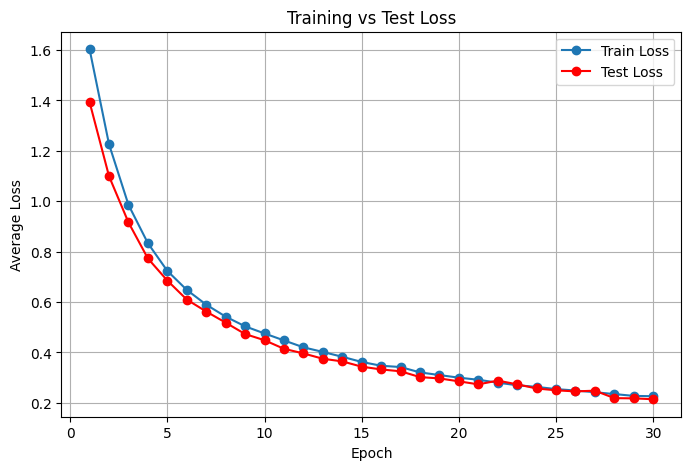

Test Accuracy: 0.9480


In [9]:
# Training starten

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = LSTM(input_size=128, hidden_size=64, num_layers=1, num_classes=6, lr=0.0005)
model.to(device)

# Trainieren
model.train_model(train_loader, test_loader, epochs=30)

# Evaluieren
model.evaluate(test_loader)

# speichern
model.save_model("lstm_batch1.pth")


--- Fold 1/5 ---
Epoch [1/30] | Train Loss: 1.3762 | Test Loss: 1.8948
Epoch [2/30] | Train Loss: 1.0442 | Test Loss: 2.0003
Epoch [3/30] | Train Loss: 0.8841 | Test Loss: 1.7879
Epoch [4/30] | Train Loss: 0.7669 | Test Loss: 2.0362
Epoch [5/30] | Train Loss: 0.7018 | Test Loss: 2.0278
Epoch [6/30] | Train Loss: 0.6389 | Test Loss: 2.2932
Epoch [7/30] | Train Loss: 0.6210 | Test Loss: 1.7467
Epoch [8/30] | Train Loss: 0.5426 | Test Loss: 2.1311
Epoch [9/30] | Train Loss: 0.5060 | Test Loss: 2.2198
Epoch [10/30] | Train Loss: 0.4345 | Test Loss: 2.1663
Epoch [11/30] | Train Loss: 0.3954 | Test Loss: 2.3758
Epoch [12/30] | Train Loss: 0.3577 | Test Loss: 2.6558
Epoch [13/30] | Train Loss: 0.3533 | Test Loss: 2.7124
Epoch [14/30] | Train Loss: 0.3112 | Test Loss: 2.2050
Epoch [15/30] | Train Loss: 0.2984 | Test Loss: 2.2976
Epoch [16/30] | Train Loss: 0.2730 | Test Loss: 1.7238
Epoch [17/30] | Train Loss: 0.2779 | Test Loss: 2.1765
Epoch [18/30] | Train Loss: 0.2676 | Test Loss: 2.1504
E

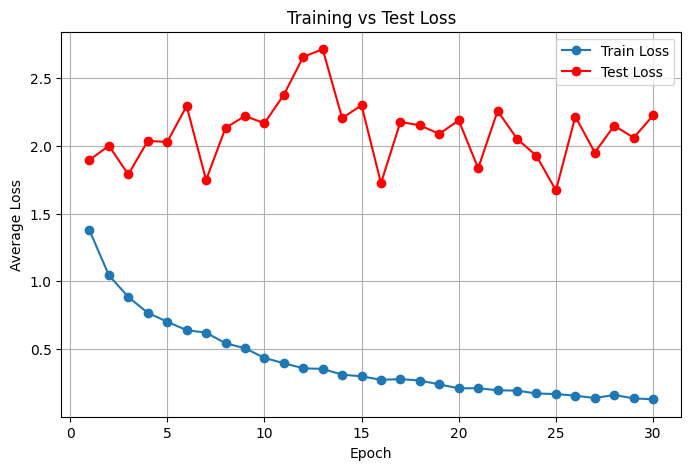

Test Accuracy: 0.9427

--- Fold 2/5 ---
Epoch [1/30] | Train Loss: 1.4114 | Test Loss: 1.8793
Epoch [2/30] | Train Loss: 1.0682 | Test Loss: 1.9107
Epoch [3/30] | Train Loss: 0.9012 | Test Loss: 1.9186
Epoch [4/30] | Train Loss: 0.7957 | Test Loss: 2.1558
Epoch [5/30] | Train Loss: 0.7097 | Test Loss: 2.6211
Epoch [6/30] | Train Loss: 0.6689 | Test Loss: 2.1955
Epoch [7/30] | Train Loss: 0.5745 | Test Loss: 2.3962
Epoch [8/30] | Train Loss: 0.5204 | Test Loss: 2.1946
Epoch [9/30] | Train Loss: 0.5790 | Test Loss: 2.4017
Epoch [10/30] | Train Loss: 0.4394 | Test Loss: 1.8433
Epoch [11/30] | Train Loss: 0.5055 | Test Loss: 2.0472
Epoch [12/30] | Train Loss: 0.3721 | Test Loss: 1.7960
Epoch [13/30] | Train Loss: 0.3362 | Test Loss: 1.8491
Epoch [14/30] | Train Loss: 0.3064 | Test Loss: 1.9853
Epoch [15/30] | Train Loss: 0.3298 | Test Loss: 2.0485
Epoch [16/30] | Train Loss: 0.2819 | Test Loss: 1.9777
Epoch [17/30] | Train Loss: 0.2550 | Test Loss: 2.1100
Epoch [18/30] | Train Loss: 0.2813

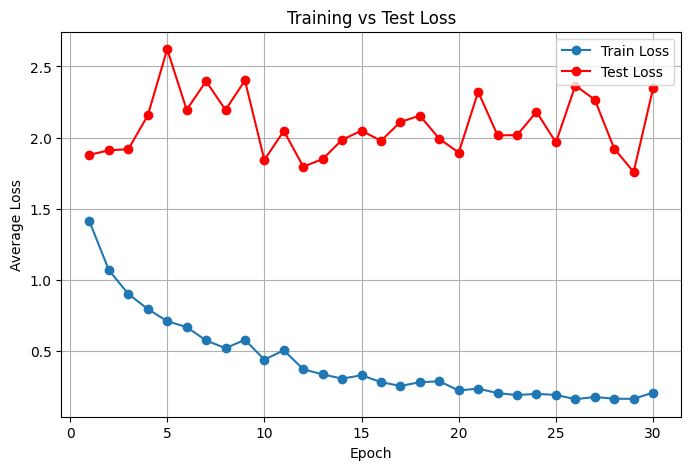

Test Accuracy: 0.9592

--- Fold 3/5 ---
Epoch [1/30] | Train Loss: 1.4036 | Test Loss: 1.8909
Epoch [2/30] | Train Loss: 1.0374 | Test Loss: 1.8373
Epoch [3/30] | Train Loss: 0.8790 | Test Loss: 1.9478
Epoch [4/30] | Train Loss: 0.7440 | Test Loss: 2.1013
Epoch [5/30] | Train Loss: 0.6911 | Test Loss: 2.1402
Epoch [6/30] | Train Loss: 0.6424 | Test Loss: 1.9502
Epoch [7/30] | Train Loss: 0.5671 | Test Loss: 2.0476
Epoch [8/30] | Train Loss: 0.5109 | Test Loss: 1.9461
Epoch [9/30] | Train Loss: 0.4627 | Test Loss: 2.0571
Epoch [10/30] | Train Loss: 0.4419 | Test Loss: 2.2771
Epoch [11/30] | Train Loss: 0.4079 | Test Loss: 2.1179
Epoch [12/30] | Train Loss: 0.3605 | Test Loss: 2.6169
Epoch [13/30] | Train Loss: 0.3461 | Test Loss: 2.0776
Epoch [14/30] | Train Loss: 0.3222 | Test Loss: 2.5661
Epoch [15/30] | Train Loss: 0.2970 | Test Loss: 2.4351
Epoch [16/30] | Train Loss: 0.3322 | Test Loss: 2.1227
Epoch [17/30] | Train Loss: 0.2623 | Test Loss: 2.2485
Epoch [18/30] | Train Loss: 0.2299

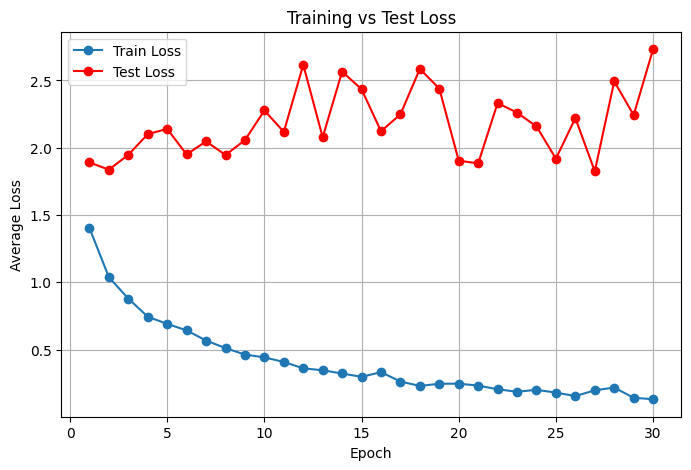

Test Accuracy: 0.9488

--- Fold 4/5 ---
Epoch [1/30] | Train Loss: 1.3685 | Test Loss: 1.7873
Epoch [2/30] | Train Loss: 0.9976 | Test Loss: 1.8927
Epoch [3/30] | Train Loss: 0.8498 | Test Loss: 1.8486
Epoch [4/30] | Train Loss: 0.7554 | Test Loss: 1.8847
Epoch [5/30] | Train Loss: 0.6684 | Test Loss: 1.9902
Epoch [6/30] | Train Loss: 0.6186 | Test Loss: 1.9499
Epoch [7/30] | Train Loss: 0.5427 | Test Loss: 2.0988
Epoch [8/30] | Train Loss: 0.5095 | Test Loss: 2.3517
Epoch [9/30] | Train Loss: 0.4793 | Test Loss: 2.0506
Epoch [10/30] | Train Loss: 0.4754 | Test Loss: 2.2761
Epoch [11/30] | Train Loss: 0.4022 | Test Loss: 2.3770
Epoch [12/30] | Train Loss: 0.3665 | Test Loss: 2.3146
Epoch [13/30] | Train Loss: 0.3902 | Test Loss: 2.4459
Epoch [14/30] | Train Loss: 0.3099 | Test Loss: 2.3094
Epoch [15/30] | Train Loss: 0.3241 | Test Loss: 2.3469
Epoch [16/30] | Train Loss: 0.2779 | Test Loss: 2.6457
Epoch [17/30] | Train Loss: 0.2558 | Test Loss: 2.4282
Epoch [18/30] | Train Loss: 0.2351

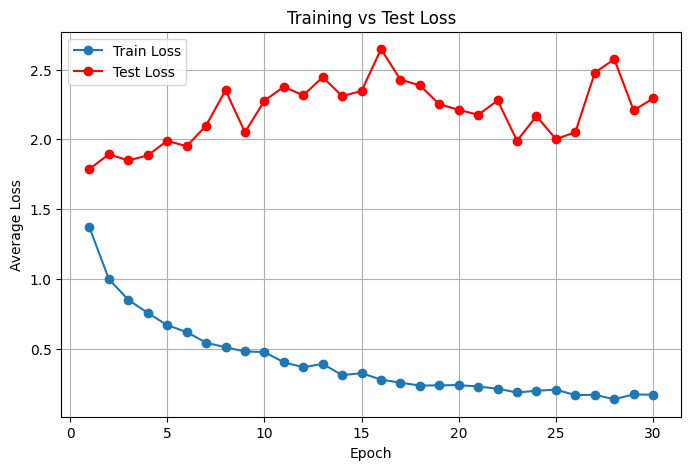

Test Accuracy: 0.9470

--- Fold 5/5 ---
Epoch [1/30] | Train Loss: 1.3538 | Test Loss: 1.8962
Epoch [2/30] | Train Loss: 1.0015 | Test Loss: 1.8166
Epoch [3/30] | Train Loss: 0.8588 | Test Loss: 1.9417
Epoch [4/30] | Train Loss: 0.7435 | Test Loss: 1.9028
Epoch [5/30] | Train Loss: 0.6836 | Test Loss: 1.8483
Epoch [6/30] | Train Loss: 0.6239 | Test Loss: 2.2588
Epoch [7/30] | Train Loss: 0.5246 | Test Loss: 2.0267
Epoch [8/30] | Train Loss: 0.4922 | Test Loss: 1.8736
Epoch [9/30] | Train Loss: 0.4730 | Test Loss: 1.8027
Epoch [10/30] | Train Loss: 0.3977 | Test Loss: 2.0386
Epoch [11/30] | Train Loss: 0.3552 | Test Loss: 2.1925
Epoch [12/30] | Train Loss: 0.3366 | Test Loss: 2.0138
Epoch [13/30] | Train Loss: 0.3663 | Test Loss: 1.7757
Epoch [14/30] | Train Loss: 0.2947 | Test Loss: 1.9779
Epoch [15/30] | Train Loss: 0.2724 | Test Loss: 2.2610
Epoch [16/30] | Train Loss: 0.2923 | Test Loss: 2.0174
Epoch [17/30] | Train Loss: 0.2443 | Test Loss: 2.3030
Epoch [18/30] | Train Loss: 0.2226

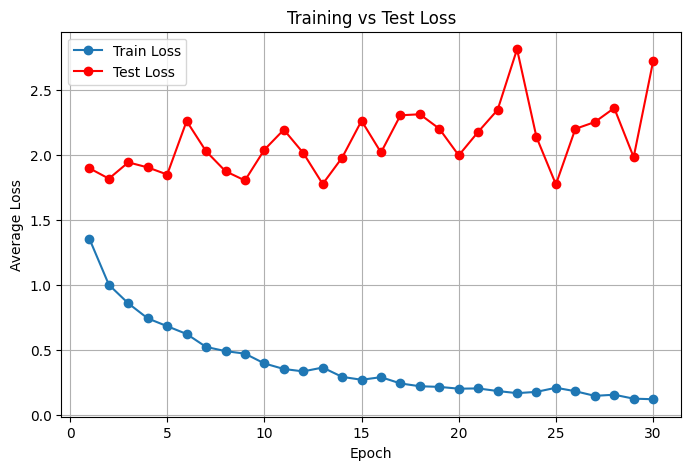

Test Accuracy: 0.9711

Average Accuracy across 5 folds: 0.9538


In [11]:
# NEU: 5-Fold Cross Validation

# Sequenzen erstellen
X_seq, y_seq = create_sequences(X, y - 1, SEQ_LEN)  # Labels 0-basiert

kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_seq)):
    print(f"\n--- Fold {fold+1}/{5} ---")

    X_train_fold, y_train_fold = X_seq[train_idx], y_seq[train_idx]
    X_val_fold, y_val_fold = X_seq[val_idx], y_seq[val_idx]

    train_dataset = GasSensorDataset(X_train_fold, y_train_fold)
    val_dataset = GasSensorDataset(X_val_fold, y_val_fold)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    # Neues Modell für jeden Fold
    model = LSTM(input_size=128, hidden_size=64, num_layers=1, num_classes=6, lr=0.0005)
    model.to(device)

    model.train_model(train_loader, test_loader, epochs=30)

    acc = model.evaluate(val_loader)
    fold_accuracies.append(acc)

# Durchschnittliche Accuracy
avg_acc = np.mean(fold_accuracies)
print(f"\nAverage Accuracy across 5 folds: {avg_acc:.4f}")